In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 한국 데이터
df = pd.read_csv("../../data/kosdaq/price.csv", index_col = 'date', parse_dates = True)
sn = pd.read_csv("../../data/kosdaq/share_number.csv", index_col = 'date', parse_dates = True)
pm = pd.read_csv("../../data/kosdaq/price_mod.csv", index_col = 'date', parse_dates = True)

In [10]:
# 시가총액
market_cap = df*sn
market_cap.index = market_cap.index + pd.tseries.offsets.MonthEnd(0)
m_cap_k = market_cap.groupby('date').last()

# 월간 수익률
pm.index = pm.index + pd.tseries.offsets.MonthEnd(0)
m_pm = pm.groupby('date').last()
m_ret_k = (m_pm.fillna(-1) / m_pm.shift(1)).clip(0, 10) - 1

In [11]:
# dataframe.rank() 시간 단축하는 함수
def fast_rank(df: pd.DataFrame, axis=1, pct=True, ascending=True) -> pd.DataFrame:
    arr = df.values.copy()
    if not ascending:
        arr = -arr
    nan_mask = np.isnan(arr)
    # argsort 2번하면 rank를 값으로 갖게 됨
    # [70, 50, 60, nan] -> [1, 2, 0, 3] -> [2, 0, 1, 3]
    rank = arr.argsort(axis=axis).argsort(axis=axis)
    rank = rank.astype(float)
    
    # 1을 더해줌
    rank += np.ones(rank.shape)
    rank[nan_mask] = np.nan
    # np.nanmax : nan을 0으로 치환하고 max값 구함
    if pct:
        rank = rank / np.nanmax(rank, axis=axis)[:, np.newaxis]
    return pd.DataFrame(rank, index=df.index, columns=df.columns)

# m_ret: monthly_return, m_vol: moonthly_volatility, n: n months
def plot_low_vol(m_ret, m_cap, n, ax=None):
    # 변동성에 따라 포트폴리오 구성 (n개월 변동성 계산)
    m_vol = m_ret.rolling(n).std()
    m_vol_rank = fast_rank(m_vol, axis=1, pct=True)
    
    # 변동성 순위에 따라 분위별 포트폴리오 구성 (변동성 낮을 수록 순위 낮음)
    p1_mask = m_vol_rank <= 0.2
    p2_mask = (m_vol_rank > 0.2) & (m_vol_rank <= 0.4)
    p3_mask = (m_vol_rank > 0.4) & (m_vol_rank <= 0.6)
    p4_mask = (m_vol_rank > 0.6) & (m_vol_rank <= 0.8)
    p5_mask = (m_vol_rank > 0.8) & (m_vol_rank <= 1.0)

    # 시가총액 가중평균
    cap_weight = [(m_cap[i].T / m_cap[i].sum(axis=1)).T for i in [p1_mask, p2_mask, p3_mask, p4_mask, p5_mask]]
    
    # 포트폴리오마다 누적 수익률 계산
    n -= 1
    ret = [(m_ret * i.shift(1)).sum(axis = 1)[n:] for i in cap_weight]
    cumul_ret = [(i + 1).cumprod() for i in ret]
    
    # 시각화
    for i, j in zip(cumul_ret, ['p1', 'p2', 'p3', 'p4', 'p5']):
        if ax:
            sns.lineplot(i.index, i, label = j, ax=ax)
        else:
            sns.lineplot(i.index, i, label = j)
    if ax:
        ax.set(title=f'{n + 1}months vol')
    else:
        plt.title(f'{n + 1}months vol')
        plt.show()

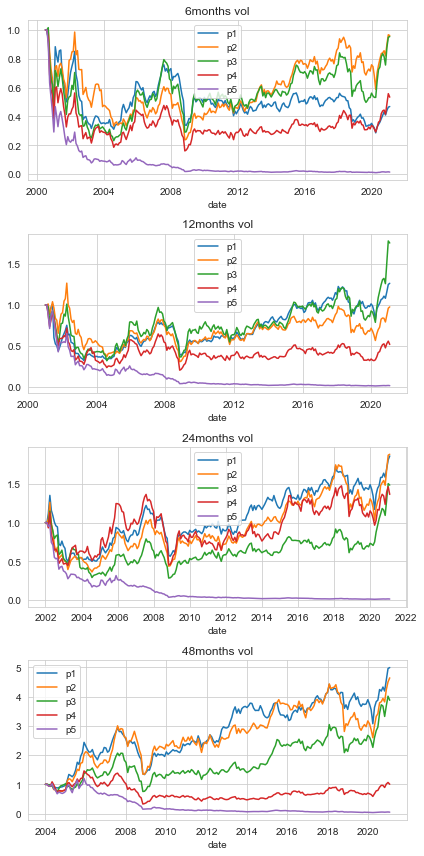

In [12]:
# left - korea, right - america
sns.set_style('whitegrid')
fig, axes = plt.subplots(4, 1, figsize=(6,12))
for i, n in zip(range(4), [6, 12, 24, 48]):
    plot_low_vol(m_ret_k, m_cap_k, n, axes[i])
plt.tight_layout()
plt.show()

In [14]:
m_vol = m_ret_k.rolling(48).std()
m_vol_rank = fast_rank(m_vol, axis=1, pct=True)
p1_mask = m_vol_rank <= 0.2
p2_mask = (m_vol_rank > 0.2) & (m_vol_rank <= 0.4)
cap_weight = [(m_cap_k[i].T / m_cap_k[i].sum(axis=1)).T for i in [p1_mask, p2_mask]]

cap_rank = m_cap_k.rank(axis=1, pct=1, ascending=False)
for i in range(2):
    total_mo = cap_rank[cap_weight[i].notna()]
    p1_ratio = (total_mo < 0.2).sum(axis=1) / total_mo.notna().sum(axis=1)
    p2_ratio = ((total_mo < 0.4) & (total_mo >= 0.2)).sum(axis=1) / total_mo.notna().sum(axis=1)
    p3_ratio = ((total_mo < 0.6) & (total_mo >= 0.4)).sum(axis=1) / total_mo.notna().sum(axis=1)
    p4_ratio = ((total_mo < 0.8) & (total_mo >= 0.6)).sum(axis=1) / total_mo.notna().sum(axis=1)
    p5_ratio = (total_mo >= 0.8).sum(axis=1) / total_mo.notna().sum(axis=1)
    print(f'p1: {round(p1_ratio.mean(), 4)}')
    print(f'p2: {round(p2_ratio.mean(), 4)}')
    print(f'p3: {round(p3_ratio.mean(), 4)}')
    print(f'p4: {round(p4_ratio.mean(), 4)}')
    print(f'p5: {round(p5_ratio.mean(), 4)}')
    print()

p1: 0.1927
p2: 0.1788
p3: 0.2038
p4: 0.2244
p5: 0.2003

p1: 0.2205
p2: 0.2106
p3: 0.1926
p4: 0.2025
p5: 0.1738

